## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install all Necessary Libraries





In [3]:
!pip install pdfminer.six bertopic umap-learn nltk spacy lbl2vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 19.8 MB/s eta 0:00:00


In [4]:
import os
import re
import unicodedata
import pandas as pd
from pdfminer.high_level import extract_text
from pdfminer.pdfparser import PDFSyntaxError
from pdfminer.pdfdocument import PDFTextExtractionNotAllowed
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import umap
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from lbl2vec import Lbl2TransformerVec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from IPython.display import display
import torch
from tqdm import tqdm
from collections import Counter
from sklearn.decomposition import PCA

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 1. Information Extraction_TASK 1


## Preprocessing and Text Extracting Functions

In [9]:
def clean_commas(authors):
    """
    Cleans up multiple commas in the author string:
    - Replaces occurrences of ',,' or more with a single comma.
    - Removes leading, trailing, and redundant commas.
    """
    authors = re.sub(r',\s*,+', ',', authors)
    authors = authors.strip(',')

    return authors


def clean_authors(authors):
    """
    Cleans the authors' string while preserving the full name structure:
    - Removes unwanted symbols like *, (), [-- -], beta symbols, extraneous commas, and other artifacts.
    - Retains the order of authors and removes unnecessary numbers or affiliations.
    - Normalizes Unicode characters.
    """
    if pd.isna(authors) or not authors.strip():
        return ''  # Return empty if no authors found

    # Normalize Unicode characters to NFKC form (preserve accents and remove unnecessary characters)
    authors = unicodedata.normalize('NFKC', authors)

    # Step 1: Remove content inside parentheses, brackets, asterisks, and other unwanted symbols
    authors = re.sub(r'\[.*?\]', '', authors)
    authors = re.sub(r'\(.*?\)', '', authors)
    authors = re.sub(r'\*', '', authors)
    authors = re.sub(r'[β‹†]', '', authors)
    authors = re.sub(r'-- -', '', authors)

    # Step 2: Remove numbers associated with affiliations
    authors = re.sub(r'\d+', '', authors)

    # Step 3: Replace "and" and "et al." with commas to separate author names
    authors = re.sub(r'\band\b|\bet al\.?', ',', authors, flags=re.IGNORECASE)

    # Step 4: Normalize spaces and clean up multiple commas
    authors = re.sub(r'\s*,\s*', ', ', authors)
    authors = re.sub(r'\s+', ' ', authors).strip()

    # Step 5: Clean up leftover Unicode artifacts that are out of context
    authors = re.sub(r'[^\w\s,.-]', '', authors)

    # Step 6: Use clean_commas function to remove any remaining redundant commas
    authors = clean_commas(authors)

    return authors


def clean_title(title):
    """
    Cleans the title by removing special characters at the end.
    Ensures the title ends with alphanumeric characters.
    """
    # Remove non-alphanumeric characters from the end of the title
    cleaned_title = re.sub(r'[^\w\s]+$', '', title).strip()

    return cleaned_title

def extract_pdf_blocks(pdf_path):
    """
    Extracts the Title, Authors, Abstract, and Keywords from a PDF file based on defined rules.

    Args:
        pdf_path (str): The path to the PDF file.

    Returns:
        dict: A dictionary containing extracted 'Title', 'Authors', 'Abstract', and 'Keywords'.
               If any part is not found, it will return an empty string for that field.
    """
    try:
        # Extract text content from the PDF
        text = extract_text(pdf_path)
        # Extract the title from the PDF
        title_match = re.search(r'(.+?)(?=\n\n)', text, re.DOTALL)
        title = title_match.group(1).replace('\n', ' ').strip() if title_match else ''
        title = clean_title(title)

        # Extract remaining content after the title
        remaining_text = text[title_match.end():] if title_match else text

        # Extract authors from the remaining text
        authors_match = re.search(r'(.+?)(?=\n\n)', remaining_text, re.DOTALL)
        authors = authors_match.group(1).strip() if authors_match else ''
        remaining_text = remaining_text[authors_match.end():] if authors_match else remaining_text

        # Extract abstract from the remaining text
        abstract_match = re.search(r'(?i)\babstract\b(.*?)(?=\n\nkeywords|Keywords|1 introduction|Introduction)', remaining_text, re.DOTALL)
        abstract = re.sub(r'^[^\w]+', '', abstract_match.group(1)).strip() if abstract_match else ''
        remaining_text_after_abstract = remaining_text[abstract_match.end():] if abstract_match else remaining_text

        # Extract keywords from the remaining text after the abstract
        keywords_match = re.search(r'(?i)\bkeywords\b(.*?)(?=\n\n1 introduction|\n\nintroduction|Introduction)', remaining_text_after_abstract, re.DOTALL)
        keywords = re.sub(r'^[^\w]+', '', keywords_match.group(1)).strip() if keywords_match else ''

        # Return extracted content as a dictionary
        return {
            'Title': title,
            'Authors': authors,
            'Abstract': abstract,
            'Keywords': keywords
        }

    except Exception as e:
        # Handle any errors during the extraction process
        print(f"Error processing file {pdf_path}: {str(e)}")
        return {
            'Title': '',
            'Authors': '',
            'Abstract': '',
            'Keywords': ''
        }


def process_all_pdfs(pdf_folder_path):
    """
    Processes all PDFs in the given folder, extracts relevant information,
    cleans the authors' names, and stores the results in a pandas DataFrame.

    Args:
        pdf_folder_path (str): Path to the folder containing PDF files.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted and cleaned data from all PDFs.
    """

    # List all PDF files in the given folder
    pdf_files = [f for f in os.listdir(pdf_folder_path) if f.endswith('.pdf')]
    data = []

    # Iterate through all PDF files in the folder and extract needed information
    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_folder_path, pdf_file)
        extracted_info = extract_pdf_blocks(pdf_path)
        cleaned_authors = clean_authors(extracted_info.get('Authors', ''))

        # Append extracted data to the list for each PDF
        data.append({
            'ID': pdf_file,
            'title': extracted_info['Title'],
            'Abstract': extracted_info['Abstract'],
            'Keywords': extracted_info['Keywords'],
            'authors': cleaned_authors,
            'Classification_label': '',  # Empty for now
        })

    df = pd.DataFrame(data)
    return df

In [10]:
def normalize_id_from_pdf_name(pdf_name):
    """
    A Helper Function to Normalize the PDF file name by stripping the `.pdf` extension and leading zeros to match with ID.
    """
    return pdf_name.replace('.pdf', '').lstrip('0')


## Evaluation Function

In [11]:
def evaluate_authors_and_titles(extracted_df, actual_df):
    """
    Evaluates the performance of the extracted author names and titles against the actual data
    by using the ID for proper mapping.

    Args:
        extracted_df (pd.DataFrame): DataFrame containing the extracted authors and titles.
        actual_df (pd.DataFrame): DataFrame containing the actual authors and titles.

    Returns:
        dict: A dictionary containing exact and partial match accuracies for authors and titles.
    """

    # Normalize IDs in both DataFrames for accurate comparison
    extracted_df['ID_normalized'] = extracted_df['ID'].apply(normalize_id_from_pdf_name)
    actual_df['ID_normalized'] = actual_df['ID'].astype(str).str.lstrip('0')

    # Merge the two dataframes on ID for proper comparison
    comparison_df = pd.merge(extracted_df, actual_df, on='ID_normalized', how='inner')

    total_entries = len(comparison_df)
    exact_author_matches = 0
    partial_author_matches = 0
    exact_title_matches = 0
    partial_title_matches = 0

    # Helper function to normalize the author names into lists for comparison
    def normalize_name_list(name_string):
        if pd.isna(name_string):
            return []
        # Split authors by comma and strip/convert to lowercase for uniformity
        return [name.strip().lower() for name in name_string.split(',') if name.strip()]

    # Iterate over each row in the comparison DataFrame to evaluate authors and titles
    for _, row in comparison_df.iterrows():
        # Author evaluation
        extracted_authors = row.get('authors', '')
        actual_authors = row.get('Authors', '')
        extracted_author_list = normalize_name_list(extracted_authors)
        actual_author_list = normalize_name_list(actual_authors)
        if extracted_author_list == actual_author_list:
            exact_author_matches += 1
        elif any(author in extracted_author_list for author in actual_author_list):
            partial_author_matches += 1

        # Title evaluation
        extracted_title = row.get('title', '')
        actual_title = row.get('Title', '')
        if extracted_title and actual_title:
            extracted_title = extracted_title.strip().lower()
            actual_title = actual_title.strip().lower()
            if extracted_title == actual_title:
                exact_title_matches += 1
            elif any(word.lower() in extracted_title for word in actual_title.split()):
                partial_title_matches += 1

     # Calculate the accuracy percentages for authors and titles
    total_valid_entries = total_entries
    author_exact_accuracy = (exact_author_matches / total_valid_entries) * 100
    author_partial_accuracy = (partial_author_matches / total_valid_entries) * 100
    title_exact_accuracy = (exact_title_matches / total_valid_entries) * 100
    title_partial_accuracy = (partial_title_matches / total_valid_entries) * 100

    evaluation_results = {
        'Author Exact Match Accuracy (%)': author_exact_accuracy,
        'Author Partial Match Accuracy (%)': author_partial_accuracy,
        'Title Exact Match Accuracy (%)': title_exact_accuracy,
        'Title Partial Match Accuracy (%)': title_partial_accuracy
    }
    return evaluation_results


## Apply Information Extraction and Evaluate Results

In [12]:
pdf_folder_path = '/content/drive/MyDrive/ICDAR2024_proceedings_pdfs'
extracted_data_df = process_all_pdfs(pdf_folder_path)

# Load the actual data from the provided CSV file
actual_data_df = pd.read_csv('/content/drive/MyDrive/ICDAR 2024 paper list.csv')  # Replace with the actual path to the paper list

# Evaluate the authors and titles accuracy
evaluation_results = evaluate_authors_and_titles(extracted_data_df, actual_data_df)

# Print the evaluation results
print(evaluation_results)

Error processing file /content/drive/MyDrive/ICDAR2024_proceedings_pdfs/0080.pdf: 'PDFObjRef' object is not iterable
Error processing file /content/drive/MyDrive/ICDAR2024_proceedings_pdfs/0064.pdf: 'PDFObjRef' object is not iterable
Error processing file /content/drive/MyDrive/ICDAR2024_proceedings_pdfs/0255.pdf: 'PDFObjRef' object is not iterable
Error processing file /content/drive/MyDrive/ICDAR2024_proceedings_pdfs/0172.pdf: 'PDFObjRef' object is not iterable
Error processing file /content/drive/MyDrive/ICDAR2024_proceedings_pdfs/C07.pdf: 'PDFObjRef' object is not iterable
{'Author Exact Match Accuracy (%)': 2.027027027027027, 'Author Partial Match Accuracy (%)': 81.08108108108108, 'Title Exact Match Accuracy (%)': 82.43243243243244, 'Title Partial Match Accuracy (%)': 14.18918918918919}


In [13]:
print(extracted_data_df.head())

         ID                                              title  \
0  0083.pdf  Impression-CLIP: Contrastive Shape-Impression ...   
1  0060.pdf  Multi-Cell Decoder and Mutual Learning for Tab...   
2  0078.pdf  Test Time Augmentation as a Defense Against Ad...   
3  0074.pdf  One-shot Transformer-based Framework for Visua...   
4  0077.pdf  Progressive Evolution from Single-Point to Pol...   

                                            Abstract  \
0  Fonts convey different impressions to readers....   
1  Extracting table contents from documents such ...   
2  Neural networks have been shown to be weak aga...   
3  There is a growing need for efficient entity e...   
4  The advancement of text shape representations ...   

                                            Keywords  \
0  Contrastive Embedding · Font style · Impressio...   
1  Deep Learning, Table Recognition, Transformer,...   
2  Online Handwriting · Adversarial Attacks · Def...   
3  Entity extraction · Visually-Rich docum

# 2. Document Classification_Task 2

## Preprocessing Functions

In [15]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')  # For sentence tokenization
nltk.download('wordnet')  # For lemmatization
nltk.download('omw-1.4')  # WordNet lemmatizer language data

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_sentence(sentence):
    """
    Preprocesses a single sentence by:
    - Lowercasing the sentence
    - Tokenizing into words
    - Removing stopwords and punctuation (non-alphabetic tokens)
    - Lemmatizing words
    - Rejoining the cleaned words back into a sentence
    """
    sentence = sentence.lower()
    tokens = word_tokenize(sentence)
    lemmatized_tokens = [
        lemmatizer.lemmatize(token) for token in tokens
        if token.isalpha() and token not in stop_words
    ]
    cleaned_sentence = ' '.join(lemmatized_tokens)

    return cleaned_sentence

def preprocess_text(row):
    """
    Preprocesses the input row by treating Title, Abstract, and Keywords as separate sentences:
    - The Title is treated as a single sentence.
    - The Abstract is split into multiple sentences using nltk's sentence tokenizer (sent_tokenize).
    - The Keywords are treated as a single sentence.

    Returns a list of cleaned and preprocessed sentences.
    """

    title = row.get('Title', '')
    abstract = row.get('Abstract', '')
    keywords = row.get('Keywords', '')

    sentences = []

    if title:
        sentences.append(preprocess_sentence(title))
    if abstract:
        abstract_sentences = sent_tokenize(abstract)
        for sentence in abstract_sentences:
            sentences.append(preprocess_sentence(sentence))
    if keywords:
        sentences.append(preprocess_sentence(keywords))
    return sentences


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Apply Preprocessing: Prepare Texts for Encoding (Abstract+Title+Keywords)

In [16]:
def apply_preprocessing(dataframe):
    """
    Applies the preprocessing function to each row of the dataframe,
    processing Title, Abstract, and Keywords as described.
    """
    dataframe['cleaned_text'] = dataframe.apply(preprocess_text, axis=1)
    return dataframe


processed_df = apply_preprocessing(extracted_data_df)
print(processed_df['cleaned_text' ].head())

# Print a random result from the dataframe for inspection
random_row = processed_df.sample(1)
random_row_cleaned_text = random_row['cleaned_text'].values[0]

print(random_row_cleaned_text)

# Display the df as a table
display(processed_df)


0    [font convey different impression reader, sion...
1    [extracting table content document scientific ...
2    [neural network shown weak sarial attack, stud...
3    [growing need efficient entity extraction ee b...
4    [advancement text shape representation towards...
Name: cleaned_text, dtype: object
['although scene text recognition achieved high mance text segmentation still need improved', 'goal text segmentation obtain foreground text mask scene image', 'paper adaptively resize input image timal scale propose refined pyramid feature fusion network robust scene text segmentation', 'address issue inconsistent text scaling propose adaptive image scaling method take account density text region scene image', 'first extract feature bone network combine feature using effective pyramid feature fusion method', 'enhance interaction text contextual character extract feature different level apply two mechanism fusion feature map spatial channel dimension', 'experimental result demonstra

,ID,title,Abstract,Keywords,authors,Classification_label,ID_normalized,cleaned_text
0,0083.pdf,Impression-CLIP: Contrastive Shape-Impression ...,Fonts convey different impressions to readers....,Contrastive Embedding · Font style · Impressio...,"Yugo Kubota, Daichi Haraguchi, Seiichi Uchida",,83,"[font convey different impression reader, sion..."
1,0060.pdf,Multi-Cell Decoder and Mutual Learning for Tab...,Extracting table contents from documents such ...,"Deep Learning, Table Recognition, Transformer,...",Takaya Kawakatsu,,60,[extracting table content document scientific ...
2,0078.pdf,Test Time Augmentation as a Defense Against Ad...,Neural networks have been shown to be weak aga...,Online Handwriting · Adversarial Attacks · Def...,"Yoh Yamashita, Brian Kenji Iwana",,78,"[neural network shown weak sarial attack, stud..."
3,0074.pdf,One-shot Transformer-based Framework for Visua...,There is a growing need for efficient entity e...,Entity extraction · Visually-Rich document und...,"Huynh Vu The, Van Pham Hoai, Jeff Yang",,74,[growing need efficient entity extraction ee b...
4,0077.pdf,Progressive Evolution from Single-Point to Pol...,The advancement of text shape representations ...,Text Representations · Text Detection · Single...,"Linger Deng, Mingxin Huang, Xudong Xie, Yulian...",,77,[advancement text shape representation towards...
...,...,...,...,...,...,...,...,...
143,0316.pdf,Federated Document Visual Question Answering: ...,An important handicap of document analysis res...,Document Understanding · Document Visual Quest...,"Khanh Nguyen, Dimosthenis Karatzas",,316,[important handicap document analysis research...
144,C01.pdf,ICDAR 2024 Competition on Artistic Text Recogn...,Artistic text is widely used in advertisements...,Artistic text recognition · Scene text recogni...,"Xudong Xie, Linger Deng, Zhifei Zhang, Zhaowen...",,C01,[artistic text widely used advertisement sloga...
145,0323.pdf,Clustering Running Titles to Understand the Pr...,We propose a novel computational approach to a...,Historical document analysis · Document proven...,"Nikolai Vogler, Kartik Goyal, Samuel V. Lemley...",,323,[propose novel computational approach cally an...
146,0285.pdf,StylusAI: Stylistic Adaptation for Robust Germ...,"In this study, we introduce StylusAI, a novel ...",Handwriting Generation · Diffusion Models· Han...,"Nauman Riaz , Saifullah Saifullah, Stefan Agne...",,285,[study introduce stylusai novel architecture l...


In [17]:
#Find mean sentence length

all_sentences = [sentence for sentences_list in processed_df['cleaned_text'] for sentence in sentences_list]
sentence_lengths = [len(sentence.split()) for sentence in all_sentences]
if sentence_lengths:
    mean_sentence_length = sum(sentence_lengths) / len(sentence_lengths)
else:
    mean_sentence_length = 0  # Handle case where there are no sentences

print(f"Overall mean sentence length (in words): {mean_sentence_length}")


Overall mean sentence length (in words): 13.115506329113924


In [18]:
#Find mean document length
document_lengths = []
for sentences_list in processed_df['cleaned_text']:

    document_length = sum(len(sentence.strip().split()) for sentence in sentences_list)
    document_lengths.append(document_length)
if document_lengths:
    mean_document_length = sum(document_lengths) / len(document_lengths)
else:
    mean_document_length = 0

print(f"Overall mean document length (in words): {mean_document_length}")


Overall mean document length (in words): 112.01351351351352


## Encode Texts with Sentence Transformers and Output Embeddings

In [19]:
# Function to preprocess the dataframe to handle empty lists or empty strings before encoding
def preprocess_empty_documents(df, column_name='cleaned_text'):
    """
    Replace any empty lists or invalid entries in the DataFrame with an empty list for further handling.

    Args:
        df (pd.DataFrame): A pandas DataFrame with documents.
        column_name (str): Name of the column to preprocess.

    Returns:
        pd.DataFrame: A pandas DataFrame with empty lists handled.
    """
    df[column_name] = df[column_name].apply(lambda x: [] if isinstance(x, list) and len(x) == 0 else x)
    return df

# Function to encode a batch of documents with a provided Sentence Transformer Model
def batch_encode_documents(df, model, batch_size=8, column_name='cleaned_text'):
    """
    Encodes documents represented as a list of sentences from the 'cleaned_text' column of a dataframe.
    The function applies mean pooling to sentence embeddings to generate document embeddings.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing lists of sentences (one list per document).
        model: The pre-trained sentence transformer model to use for encoding.
        batch_size (int): The number of documents to process in each batch. Default is 8.
        column_name (str): The name of the column to use for encoding.

    Returns:
        Tuple: (document embeddings as np.ndarray, list of joined text for each document)
    """
    # Preprocess the dataframe to handle empty lists
    df = preprocess_empty_documents(df, column_name)

    document_embeddings = []
    document_texts = []  # To store the joined sentences as strings
    embedding_dim = model.get_sentence_embedding_dimension()  # Get embedding dimension from the model

    # Process the dataframe in batches
    for i in tqdm(range(0, len(df), batch_size), desc="Encoding Batches"):
        batch = df.iloc[i:i + batch_size]

        # List to hold embeddings for the current batch
        batch_embeddings = []
        batch_texts = []

        for document in batch[column_name]:
            if isinstance(document, list) and len(document) > 0:
                # Calculate sentence embeddings for each sentence in the document
                sentence_embeddings = model.encode(document, show_progress_bar=False)

                # Perform mean pooling to get the document embedding (average of sentence embeddings)
                document_embedding = np.mean(sentence_embeddings, axis=0)

                # Join the list of sentences into a single string for the document
                document_text = ' '.join(document)
            else:
                # Handle empty documents by creating a zero vector of the same dimensionality
                document_embedding = np.zeros(embedding_dim)
                document_text = ""

            # Store the embeddings and the joined document text
            batch_embeddings.append(document_embedding)
            batch_texts.append(document_text)

        # Extend the document embeddings and texts with the current batch
        document_embeddings.extend(batch_embeddings)
        document_texts.extend(batch_texts)

    # Return the document embeddings and the list of joined texts
    return np.array(document_embeddings), document_texts


# Experiments 1: Topic Modeling with BERTopic

In [20]:
from bertopic import BERTopic
import umap
import numpy as np
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import torch


# Step 1: Apply BERTopic using precomputed embeddings, with tunable UMAP and HDBSCAN parameters
def apply_bertopic_with_embeddings(documents, embeddings,
                                   n_neighbors=30, min_dist=0.1, min_cluster_size=5,
                                   min_samples=1, metric='euclidean', random_state=42):
    """
    Apply BERTopic with precomputed embeddings and explicitly assign -1 to documents with zero embeddings.

    Args:
        documents (list): The original text documents.
        embeddings (np.ndarray): The precomputed document embeddings.
        n_neighbors (int): Number of UMAP neighbors.
        min_dist (float): UMAP minimum distance.
        min_cluster_size (int): HDBSCAN minimum cluster size.
        min_samples (int): HDBSCAN minimum samples.
        metric (str): Distance metric used in HDBSCAN.
        random_state (int): Random state for UMAP to ensure reproducapility.

    Returns:
        topic_model (BERTopic): Trained BERTopic model.
        topics (np.ndarray): Array of topics for each document.
    """
    # Set up UMAP and HDBSCAN models
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    cluster_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric)
    topic_model = BERTopic(umap_model=umap_model, hdbscan_model=cluster_model)

    # Fit the model using both documents and embeddings
    topics, _ = topic_model.fit_transform(documents, embeddings)

    # Convert topics to a NumPy array
    topics = np.array(topics)

    # Detect zero embeddings and mark them as outliers (topic = -1)
    zero_embedding_indices = np.where(np.all(embeddings == 0, axis=1))[0]
    topics[zero_embedding_indices] = -1

    return topic_model, topics

# Function to print cluster details including number of documents per topic and representative words
def print_cluster_details(topic_model, topics, df, column_name='cleaned_text'):
    """
    Prints detailed information about each topic, including the number of documents in each topic and
    the most representative words for each topic.

    Args:
        topic_model (BERTopic): The trained BERTopic model.
        topics (np.ndarray): Array of topic labels for each document.
        df (pd.DataFrame): DataFrame containing the documents.
        column_name (str): The name of the column with the cleaned text.
    """
    # Get topic information
    topic_info = topic_model.get_topic_info()

    # Print the number of documents in each topic
    print("\n### Number of documents in each topic ###")
    valid_topics = topics[topics != -1]
    topic_counts = np.bincount(valid_topics)
    for topic_idx, count in enumerate(topic_counts):
        print(f"Topic {topic_idx}: {count} documents")

    # Print most representative words for each topic
    print("\n### Representative Words for Each Topic ###")
    for topic in topic_info["Topic"]:
        if topic != -1:
            representative_words = topic_model.get_topic(topic)
            print(f"\nTopic {topic}:")
            for word, importance in representative_words:
                print(f" - {word}: {importance:.4f}")



def evaluate_topic_coherence(topic_model, documents, coherence_type='c_v', topn=10):
    """
    Evaluate topic coherence using the topn most important words for each topic.

    Args:
        topic_model (BERTopic): The trained BERTopic model.
        documents (list): List of original text documents.
        coherence_type (str): Type of coherence to compute ('c_v' or others).
        topn (int): Number of top words to consider for coherence calculation.

    Returns:
        float: Coherence score for the topic model.
    """
    topics = topic_model.get_topics()

    # Prepare a list of topics with at least topn words
    top_words = [
        [word for word, _ in topic[:topn]]
        for topic_id, topic in topics.items()
        if topic_id != -1 and len(topic) >= topn
    ]

    if len(top_words) == 0:
        print("No topics with sufficient top words for coherence evaluation.")
        return None

    # Tokenize the text data for CoherenceModel
    tokenized_text = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_text)
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    coherence_model = CoherenceModel(
        topics=top_words,
        texts=tokenized_text,
        corpus=corpus,
        dictionary=dictionary,
        coherence=coherence_type
    )
    coherence_score = coherence_model.get_coherence()
    return coherence_score


# Step 4: Evaluate Topic Diversity
def topic_diversity(topic_model, top_n_words=10):
    topics = topic_model.get_topics()
    top_words = set()
    total_words = 0
    for topic_id, topic in topics.items():
        if topic_id != -1:
            words = [word for word, _ in topic[:top_n_words]]
            top_words.update(words)
            total_words += len(words)
    diversity_score = len(top_words) / total_words if total_words > 0 else 0
    return diversity_score

# Step 5: Evaluate Silhouette Score
def evaluate_bertopic_silhouette(embeddings, topics):
    valid_indices = np.where(topics != -1)[0]
    valid_embeddings = embeddings[valid_indices]
    valid_topics = topics[valid_indices]
    if len(np.unique(valid_topics)) > 1:
        silhouette_avg = silhouette_score(valid_embeddings, valid_topics, metric='cosine')
        return silhouette_avg
    return None

def full_bertopic_workflow(documents, embeddings,
                           n_neighbors=30, min_dist=0.1, min_cluster_size=5,
                           min_samples=1, metric='euclidean', random_state=42):
    """
    Full workflow for running BERTopic, assigning outliers, and evaluating results.

    Args:
        documents (list): List of original text documents.
        embeddings (np.ndarray): Precomputed document embeddings.
        n_neighbors (int): Number of UMAP neighbors.
        min_dist (float): UMAP minimum distance.
        min_cluster_size (int): HDBSCAN minimum cluster size.
        min_samples (int): HDBSCAN minimum samples.
        metric (str): Distance metric used in HDBSCAN.
        random_state (int): Random state for UMAP.

    Returns:
        dict: Evaluation results including coherence score, diversity score, and silhouette score.
    """
    # Apply BERTopic using both documents and embeddings
    topic_model, topics = apply_bertopic_with_embeddings(
        documents, embeddings,
        n_neighbors=n_neighbors, min_dist=min_dist, min_cluster_size=min_cluster_size,
        min_samples=min_samples, metric=metric, random_state=random_state
    )

    # Perform evaluations
    coherence_score = evaluate_topic_coherence(topic_model, documents)  # Use documents directly
    diversity_score = topic_diversity(topic_model)
    silhouette_score_value = evaluate_bertopic_silhouette(embeddings, topics)

    # Print detailed information about clusters (topics)
    print(f"\nNumber of outliers: {np.sum(topics == -1)}")
    print(f"Number of valid topics: {len(np.unique(topics)) - 1}")  # Exclude outliers (-1)
    print_cluster_details(topic_model, topics, processed_df, column_name='cleaned_text')

    return {
        "topic_model": topic_model,
        "topics": topics,
        "coherence_score": coherence_score,
        "diversity_score": diversity_score,
        "silhouette_score": silhouette_score_value
    }


# Step 7: Run experiments with different models and parameters
def run_experiments(df, batch_size=8):
    """
    Run multiple experiments with different models and parameters.

    Args:
        df (pd.DataFrame): DataFrame with the documents and text data.
        batch_size (int): Batch size for embedding generation.
    """
    models = ["all-mpnet-base-v2", "all-MiniLM-L6-v2"]
    n_neighbors_list = [15, 30]  # Different UMAP neighbors
    min_dist_list = [0.1, 0.5]  # Different UMAP distances
    min_cluster_size_list = [15, 25]  # Different HDBSCAN cluster sizes

    # Extract documents (text)
    documents = df['cleaned_text'].tolist()

    for model_name in models:
        print(f"\nRunning experiments for model: {model_name}")
        model = SentenceTransformer(model_name)
        if torch.cuda.is_available():
            model = model.to('cuda')
            print(f"Model {model_name} moved to GPU.")
        else:
            print(f"CUDA is not available. Running {model_name} on CPU.")
        model.max_seq_length = 200

        # Generate document embeddings using the SentenceTransformer model
        document_embeddings, joined_texts = batch_encode_documents(df, model, batch_size=batch_size)
        print(f"Shape of document embeddings: {document_embeddings.shape}")

        # Loop over the UMAP and HDBSCAN parameters
        for n_neighbors in n_neighbors_list:
            for min_dist in min_dist_list:
                for min_cluster_size in min_cluster_size_list:
                    print(f"\nExperiment with: n_neighbors={n_neighbors}, min_dist={min_dist}, min_cluster_size={min_cluster_size}")

                    # Pass both the documents (text) and document embeddings
                    results = full_bertopic_workflow(
                        joined_texts, document_embeddings,
                        n_neighbors=n_neighbors, min_dist=min_dist, min_cluster_size=min_cluster_size,
                        min_samples=1, metric='euclidean', random_state=42
                    )
                    print(f"Coherence Score: {results['coherence_score']}")
                    print(f"Topic Diversity: {results['diversity_score']}")
                    print(f"Silhouette Score: {results['silhouette_score']}")


In [21]:
run_experiments(processed_df, batch_size=8)


Running experiments for model: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model all-mpnet-base-v2 moved to GPU.


Encoding Batches: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s]


Shape of document embeddings: (148, 768)

Experiment with: n_neighbors=15, min_dist=0.1, min_cluster_size=15

Number of outliers: 66
Number of valid topics: 3

### Number of documents in each topic ###
Topic 0: 39 documents
Topic 1: 24 documents
Topic 2: 19 documents

### Representative Words for Each Topic ###

Topic 0:
 - recognition: 0.0741
 - text: 0.0741
 - character: 0.0482
 - model: 0.0385
 - font: 0.0374
 - task: 0.0341
 - image: 0.0332
 - handwriting: 0.0310
 - dataset: 0.0306
 - method: 0.0300

Topic 1:
 - image: 0.0731
 - document: 0.0564
 - model: 0.0563
 - music: 0.0390
 - approach: 0.0374
 - method: 0.0366
 - learning: 0.0365
 - analysis: 0.0348
 - text: 0.0342
 - data: 0.0325

Topic 2:
 - graph: 0.0684
 - information: 0.0613
 - extraction: 0.0556
 - relation: 0.0433
 - document: 0.0415
 - text: 0.0413
 - model: 0.0401
 - process: 0.0378
 - entity: 0.0348
 - task: 0.0319
Coherence Score: 0.40580452406360806
Topic Diversity: 0.7333333333333333
Silhouette Score: 0.076686175

Encoding Batches: 100%|██████████| 19/19 [00:01<00:00, 14.47it/s]


Shape of document embeddings: (148, 384)

Experiment with: n_neighbors=15, min_dist=0.1, min_cluster_size=15

Number of outliers: 33
Number of valid topics: 4

### Number of documents in each topic ###
Topic 0: 35 documents
Topic 1: 34 documents
Topic 2: 26 documents
Topic 3: 20 documents

### Representative Words for Each Topic ###

Topic 0:
 - text: 0.0880
 - recognition: 0.0716
 - scene: 0.0466
 - character: 0.0376
 - task: 0.0345
 - language: 0.0340
 - method: 0.0310
 - word: 0.0309
 - model: 0.0306
 - detection: 0.0272

Topic 1:
 - document: 0.0976
 - model: 0.0562
 - information: 0.0475
 - extraction: 0.0437
 - task: 0.0388
 - graph: 0.0364
 - layout: 0.0344
 - entity: 0.0287
 - understanding: 0.0281
 - data: 0.0280

Topic 2:
 - text: 0.0463
 - handwriting: 0.0460
 - image: 0.0454
 - model: 0.0365
 - recognition: 0.0343
 - handwritten: 0.0323
 - music: 0.0317
 - approach: 0.0303
 - document: 0.0283
 - htr: 0.0279

Topic 3:
 - document: 0.0488
 - image: 0.0432
 - learning: 0.0380


# Experiments 2: Clustering with K-means

In [31]:
# Function to apply K-Means clustering
def apply_kmeans_clustering(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels, kmeans

# Step 1: Initialize the SentenceTransformer model
model = SentenceTransformer("all-mpnet-base-v2")

# Check if CUDA is available and move the model to GPU for faster encoding
if torch.cuda.is_available():
    model = model.to('cuda')

# Set the max sequence length to 200
model.max_seq_length = 200

document_embeddings, document_texts = batch_encode_documents(processed_df, model, batch_size=8)

# Experiment with different numbers of clusters
num_clusters_list = [2, 7, 10]  # You can experiment with different values
kmeans_results = {}

for num_clusters in num_clusters_list:
    print(f"Applying K-Means with {num_clusters} clusters...")
    cluster_labels, kmeans_model = apply_kmeans_clustering(document_embeddings, num_clusters)
    kmeans_results[num_clusters] = cluster_labels

    #


Encoding Batches: 100%|██████████| 19/19 [00:02<00:00,  6.49it/s]

Applying K-Means with 2 clusters...
Applying K-Means with 7 clusters...
Applying K-Means with 10 clusters...


In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def evaluate_kmeans_clustering(embeddings, cluster_labels, num_clusters):
    """
    Evaluates clustering performance using several metrics:
    - Silhouette Score
    - Cluster Coherence (within-cluster similarity)
    - Cluster Diversity (inter-cluster dissimilarity)
    """
    unique_clusters = np.unique(cluster_labels)

    # Silhouette Score: only applicable if there is more than 1 cluster
    if len(unique_clusters) > 1:
        silhouette = silhouette_score(embeddings, cluster_labels, metric='cosine')
    else:
        silhouette = None
        print("Silhouette score cannot be computed with a single cluster.")

    # Cluster Coherence: average pairwise similarity within each cluster
    cluster_coherence_scores = []
    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 1:
            cluster_embeddings = embeddings[cluster_indices]
            pairwise_similarities = cosine_similarity(cluster_embeddings)
            # Get the upper triangle of the similarity matrix (excluding the diagonal)
            upper_triangle = np.triu_indices(pairwise_similarities.shape[0], k=1)
            coherence = np.mean(pairwise_similarities[upper_triangle])
            cluster_coherence_scores.append(coherence)
        else:
            # Single document clusters are considered to have 0 coherence
            cluster_coherence_scores.append(0)

    avg_cluster_coherence = np.mean(cluster_coherence_scores)

    # Cluster Diversity: based on centroid dissimilarity (1 - average cosine similarity between centroids)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)
    centroids = kmeans.cluster_centers_
    pairwise_centroid_similarities = cosine_similarity(centroids)
    # Use the upper triangle of the matrix to avoid diagonal (self-similarities)
    diversity = 1 - np.mean(pairwise_centroid_similarities[np.triu_indices_from(pairwise_centroid_similarities, k=1)])

    return silhouette, avg_cluster_coherence, diversity


# Evaluate K-Means clustering for each cluster configuration
for num_clusters, cluster_labels in kmeans_results.items():
    print(f"\nEvaluating K-Means with {num_clusters} clusters...")

    # Evaluate the clustering results
    silhouette, avg_cluster_coherence, cluster_diversity = evaluate_kmeans_clustering(document_embeddings, cluster_labels, num_clusters)

    # Print evaluation metrics
    print(f"Silhouette Score: {silhouette}")
    print(f"Average Cluster Coherence (adapted from topic coherence): {avg_cluster_coherence}")
    print(f"Cluster Diversity (adapted from topic diversity): {cluster_diversity}")



Evaluating K-Means with 2 clusters...
Silhouette Score: 0.10196901348945228
Average Cluster Coherence (adapted from topic coherence): 0.4564250328735693
Cluster Diversity (adapted from topic diversity): 0.10233327892493294

Evaluating K-Means with 7 clusters...
Silhouette Score: 0.01820077181747774
Average Cluster Coherence (adapted from topic coherence): 0.5532016393966841
Cluster Diversity (adapted from topic diversity): 0.21005714408698495

Evaluating K-Means with 10 clusters...
Silhouette Score: 0.08762576465998868
Average Cluster Coherence (adapted from topic coherence): 0.5442689229463417
Cluster Diversity (adapted from topic diversity): 0.44537190807018845


In [34]:
# Apply K-Means with 2 clusters
print(f"Applying K-Means with 2 clusters...")
cluster_labels, kmeans_model = apply_kmeans_clustering(document_embeddings, num_clusters=2)

# Assign the cluster labels to the DataFrame
processed_df['cluster'] = cluster_labels

Applying K-Means with 2 clusters...


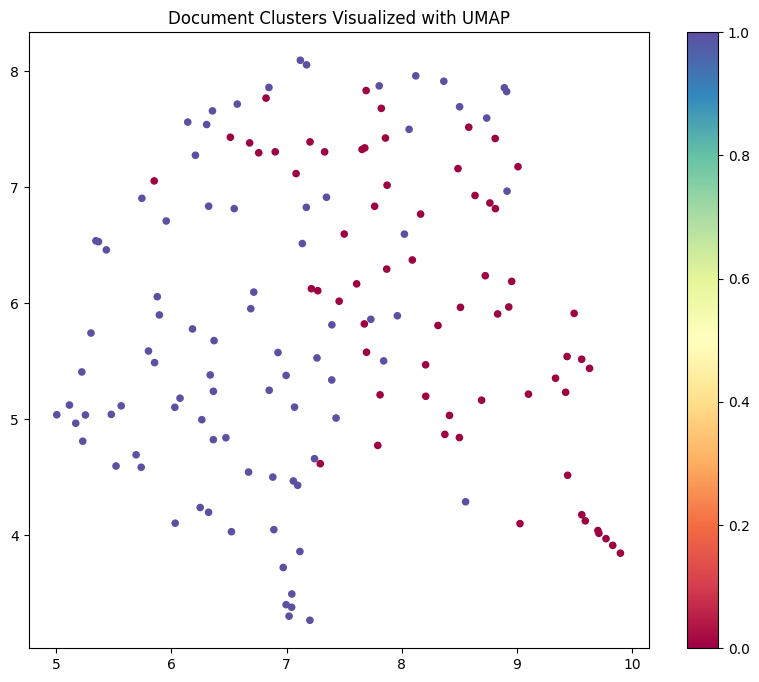

In [35]:
# Step 1: Visualizing Clusters with UMAP
def visualize_clusters(embeddings, cluster_labels):
    """
    Reduces document embeddings to 2D using UMAP and visualizes them with cluster labels.
    """
    # Reduce the dimensionality of the document embeddings using UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)

    # Plot the reduced embeddings with their cluster labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', s=20)
    plt.colorbar(scatter)
    plt.title('Document Clusters Visualized with UMAP')
    plt.show()

# Call the function to visualize the clusters
visualize_clusters(document_embeddings, processed_df['cluster'])

In [36]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import numpy as np


In [37]:
# Step 1: Apply PCA to reduce dimensionality
def apply_pca(embeddings, n_components=50):
    """
    Applies PCA to reduce dimensionality of embeddings.
    :param embeddings: The original high-dimensional document embeddings
    :param n_components: The number of dimensions to reduce to
    :return: Reduced embeddings
    """
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Step 2: Apply PCA to the document embeddings
n_components = 20  # You can experiment with different values
reduced_embeddings = apply_pca(document_embeddings, n_components)

print(f"Original shape: {document_embeddings.shape}, Reduced shape: {reduced_embeddings.shape}")

# Step 3: Apply K-Means clustering on the reduced embeddings
def apply_kmeans_clustering(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels, kmeans

# Set the number of clusters
num_clusters = 10

# Apply K-Means clustering on the reduced embeddings
cluster_labels, kmeans_model = apply_kmeans_clustering(reduced_embeddings, num_clusters)

# Evaluate the clustering results
silhouette, avg_cluster_coherence, cluster_diversity = evaluate_kmeans_clustering(document_embeddings, cluster_labels, num_clusters)

# Print evaluation metrics
print(f"Silhouette Score: {silhouette}")
print(f"Average Cluster Coherence (adapted from topic coherence): {avg_cluster_coherence}")
print(f"Cluster Diversity (adapted from topic diversity): {cluster_diversity}")



Original shape: (148, 768), Reduced shape: (148, 20)
Silhouette Score: 0.0546080309224181
Average Cluster Coherence (adapted from topic coherence): 0.5306251339052863
Cluster Diversity (adapted from topic diversity): 0.44537190807018845


# Experiments 3: Lbl2TransformerVec

2024-10-12 18:25:09,678 - Lbl2TransformerVec - INFO - Compute keyword embeddings
INFO:Lbl2TransformerVec:Compute keyword embeddings


CUDA is available. Model moved to GPU.


2024-10-12 18:25:18,579 - Lbl2TransformerVec - INFO - Compute document embeddings
INFO:Lbl2TransformerVec:Compute document embeddings
2024-10-12 18:29:34,846 - Lbl2TransformerVec - INFO - Train label embeddings
INFO:Lbl2TransformerVec:Train label embeddings
2024-10-12 18:29:34,948 - Lbl2TransformerVec - INFO - Get document embeddings from model
INFO:Lbl2TransformerVec:Get document embeddings from model
2024-10-12 18:29:34,951 - Lbl2TransformerVec - INFO - Calculate document<->label similarities
INFO:Lbl2TransformerVec:Calculate document<->label similarities



### Sample of `most_similar_label` Before Mapping ###
   doc_key most_similar_label  highest_similarity_score
0        0            label_3                  0.512948
1        1            label_0                  0.809883
2        2            label_3                  0.437467
3        3            label_2                  0.736724
4        4            label_3                  0.521071
Using 10th percentile. Documents with similarity scores below 0.3881 will be labeled as 'Others'.


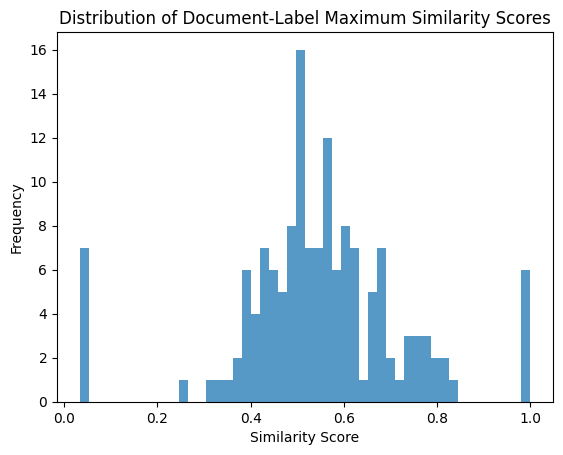


### Category Counts ###
final_label
Key Information Extraction       70
Others                           27
Datasets                         27
Classification                   13
Optical Character Recognition     9
Tables                            2
Name: count, dtype: int64

### Final Processed DataFrame with 'Classification' Labels ###
                                            Abstract  \
0  Fonts convey different impressions to readers....   
1  Extracting table contents from documents such ...   
2  Neural networks have been shown to be weak aga...   
3  There is a growing need for efficient entity e...   
4  The advancement of text shape representations ...   

               Classification  
0  Key Information Extraction  
1                      Others  
2  Key Information Extraction  
3              Classification  
4  Key Information Extraction  


In [28]:
from lbl2vec import Lbl2TransformerVec
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import random


def set_random_seed(seed=42):
    """Set the random seed for reproducibility."""

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def initialize_lbl2vec(documents, predefined_keywords, transformer_model_name="all-mpnet-base-v2", clean_outliers=False):
    """Initialize and fit the Lbl2Vec model."""

    # Set the random seed for reproducibility
    set_random_seed()

    # Initialize the SentenceTransformer model
    model = SentenceTransformer(transformer_model_name)

    # Ensure that the model uses GPU explicitly, if available
    if torch.cuda.is_available():
        model = model.to('cuda')
        print("CUDA is available. Model moved to GPU.")
    else:
        print("CUDA is not available. Using CPU.")

    # Initialize Lbl2TransformerVec
    lbl2vec_model = Lbl2TransformerVec(
        documents=documents,
        keywords_list=predefined_keywords,
        transformer_model=model,
        clean_outliers=clean_outliers
    )

    # Fit the model
    lbl2vec_model.fit()

    return lbl2vec_model


def map_labels_to_categories(doc_similarities_df, label_mapping):

    """Map the internal labels (like label_1) to predefined categories."""


    # Print a sample of the output from predict_model_docs to verify labels
    print("\n### Sample of `most_similar_label` Before Mapping ###")
    print(doc_similarities_df[['doc_key', 'most_similar_label', 'highest_similarity_score']].head())

    # Map the predicted internal labels to the actual categories
    doc_similarities_df['mapped_label'] = doc_similarities_df['most_similar_label'].map(label_mapping)

    # If a label is not found in the label mapping, assign it as "Others"
    doc_similarities_df['mapped_label'].fillna("Others", inplace=True)

    return doc_similarities_df


def handle_outliers(doc_similarities_df, percentile_threshold=10):

    """Handle outliers by assigning them to the 'Others' category."""

    similarity_scores = doc_similarities_df['highest_similarity_score']

    # Calculate the threshold based on the percentile
    similarity_threshold = np.percentile(similarity_scores, percentile_threshold)

    print(f"Using {percentile_threshold}th percentile. Documents with similarity scores below {similarity_threshold:.4f} will be labeled as 'Others'.")

    # Assign "Others" label to documents below the threshold
    final_labels = []
    for label, similarity in zip(doc_similarities_df['mapped_label'], similarity_scores):
        if similarity < similarity_threshold:
            final_labels.append("Others")
        else:
            final_labels.append(label)

    # Add final labels to the DataFrame
    doc_similarities_df['final_label'] = final_labels

    return doc_similarities_df, similarity_threshold


def count_documents_per_category(doc_similarities_df):

    """Return the count of documents in each category."""

    category_counts = doc_similarities_df['final_label'].value_counts()
    return category_counts


def plot_similarity_histogram(doc_similarities_df):

    """Plot histogram for the similarity score distribution."""

    similarity_scores = doc_similarities_df['highest_similarity_score']
    plt.hist(similarity_scores, bins=50, alpha=0.75)
    plt.title('Distribution of Document-Label Maximum Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.show()


# RUn the entire workflow and add the labels to the original DataFrame

def run_lbl2vec_workflow(processed_df, category_keywords, label_mapping, percentile_threshold=10):

    """Run the Lbl2Vec workflow and return results, including labels added to processed_df."""

    # Prepare the documents (use abstracts or other text fields)
    documents = processed_df['Abstract'].fillna('empty').tolist()
    documents = ['empty' if doc.strip() == '' else doc.strip() for doc in documents]

    # Initialize and fit Lbl2Vec
    predefined_keywords = [keywords for keywords in category_keywords.values()]
    lbl2vec_model = initialize_lbl2vec(documents, predefined_keywords)

    # Get document similarities and predictions
    doc_similarities_df = lbl2vec_model.predict_model_docs()

    # Map labels to actual categories
    doc_similarities_df = map_labels_to_categories(doc_similarities_df, label_mapping)

    # Handle outliers by assigning "Others" category
    doc_similarities_df, similarity_threshold = handle_outliers(doc_similarities_df, percentile_threshold)

    # Ensure all documents have a label (even if not falling into outliers)
    doc_similarities_df['final_label'].fillna("Others", inplace=True)

    # Count how many documents are classified under each category
    category_counts = count_documents_per_category(doc_similarities_df)

    # Plot the similarity scores distribution
    plot_similarity_histogram(doc_similarities_df)

    # Add the 'final_label' to the original DataFrame as "Classification"
    processed_df['Classification'] = doc_similarities_df['final_label'].values

    return processed_df, category_counts


# category_keywords and label_mapping
category_keywords = {
    "Tables": ["data table", "table extraction", "tabular data", "structured data",
               "table recognition", "table format", "data cell", "row", "column",
               "spreadsheet", "pivot table", "table detection", "HTML table",
               "table parsing", "metadata table", "table-based data extraction"],

    "Classification": ["classifier", "prediction", "supervised learning", "model",
                       "unsupervised", "labels", "accuracy", "results",
                       "classification model", "categorization", "decision tree",
                       "random forest", "classification algorithm", "logistic regression",
                       "SVM", "multiclass classification", "binary classification",
                       "class label", "predictive model"],

    "Key Information Extraction": ["information extraction", "key phrase extraction",
                                   "named entity recognition (NER)", "fact extraction",
                                   "relationship extraction", "semantic extraction",
                                   "text mining", "text analysis", "knowledge extraction",
                                   "fact-based extraction", "automated extraction",
                                   "term extraction", "entity linking", "event extraction",
                                   "fact recognition", "data mining"],

    "Optical Character Recognition": ["OCR", "text recognition", "image-to-text",
                                      "handwriting recognition", "character recognition",
                                      "digit recognition", "image text", "document scanning",
                                      "optical scanning", "scene text", "text extraction from image",
                                      "text scanner", "digital text extraction", "text detection",
                                      "printed text recognition"],

    "Datasets": ["dataset", "benchmark dataset", "data repository", "training data",
                 "test data", "validation data", "open dataset", "data collection",
                 "data labeling", "dataset creation", "data augmentation", "data preparation",
                 "data cleaning", "annotated dataset", "synthetic data"],

    "Document Layout Understanding": ["document layout", "layout recognition", "page layout",
                                      "document segmentation", "layout analysis", "layout detection",
                                      "document structure", "visual elements", "layout decomposition",
                                      "page zone segmentation", "spatial layout", "document analysis",
                                      "layout understanding", "visual structure", "content region extraction",
                                      "visual segmentation", "document grid", "layout pattern",
                                      "document visualization"]
}

label_mapping = {
    "label_1": "Tables",
    "label_2": "Classification",
    "label_3": "Key Information Extraction",
    "label_4": "Optical Character Recognition",
    "label_5": "Datasets",
    "label_6": "Document Layout Understanding"
}


processed_df, category_counts = run_lbl2vec_workflow(processed_df, category_keywords, label_mapping)

# Print the results
print("\n### Category Counts ###")
print(category_counts)

print("\n### Final Processed DataFrame with 'Classification' Labels ###")
print(processed_df[['Abstract', 'Classification']].head())


In [ ]:
#processed_df.to_csv('output_file.csv', index=False)

## Use Keywords Instead of Abstract to semantically represent each text  

2024-10-12 18:32:18,329 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2024-10-12 18:32:18,329 - Lbl2TransformerVec - INFO - Compute keyword embeddings
INFO:Lbl2TransformerVec:Compute keyword embeddings


CUDA is available. Model moved to GPU.


2024-10-12 18:32:25,965 - Lbl2TransformerVec - INFO - Compute document embeddings
2024-10-12 18:32:25,965 - Lbl2TransformerVec - INFO - Compute document embeddings
INFO:Lbl2TransformerVec:Compute document embeddings
2024-10-12 18:35:36,903 - Lbl2TransformerVec - INFO - Train label embeddings
2024-10-12 18:35:36,903 - Lbl2TransformerVec - INFO - Train label embeddings
INFO:Lbl2TransformerVec:Train label embeddings
2024-10-12 18:35:37,006 - Lbl2TransformerVec - INFO - Get document embeddings from model
2024-10-12 18:35:37,006 - Lbl2TransformerVec - INFO - Get document embeddings from model
INFO:Lbl2TransformerVec:Get document embeddings from model
2024-10-12 18:35:37,016 - Lbl2TransformerVec - INFO - Calculate document<->label similarities
2024-10-12 18:35:37,016 - Lbl2TransformerVec - INFO - Calculate document<->label similarities
INFO:Lbl2TransformerVec:Calculate document<->label similarities



### Sample of `most_similar_label` Before Mapping ###
   doc_key most_similar_label  highest_similarity_score
0        0            label_3                  0.258817
1        1            label_0                  0.617227
2        2            label_1                  0.408228
3        3            label_2                  0.545333
4        4            label_3                  0.637289
Using 10th percentile. Documents with similarity scores below 0.2689 will be labeled as 'Others'.


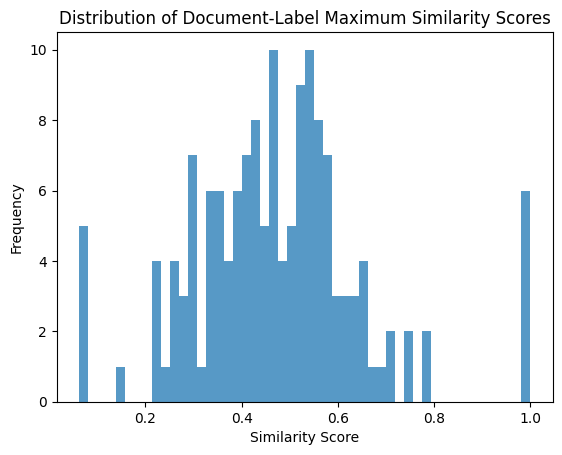


### Category Counts ###
final_label
Key Information Extraction       51
Classification                   37
Others                           25
Datasets                         23
Tables                            6
Optical Character Recognition     6
Name: count, dtype: int64
                                            Keywords  \
0  Contrastive Embedding · Font style · Impressio...   
1  Deep Learning, Table Recognition, Transformer,...   
2  Online Handwriting · Adversarial Attacks · Def...   
3  Entity extraction · Visually-Rich document und...   
4  Text Representations · Text Detection · Single...   

                                               title  \
0  Impression-CLIP: Contrastive Shape-Impression ...   
1  Multi-Cell Decoder and Mutual Learning for Tab...   
2  Test Time Augmentation as a Defense Against Ad...   
3  One-shot Transformer-based Framework for Visua...   
4  Progressive Evolution from Single-Point to Pol...   

               Classification  
0              

In [29]:
import re
from lbl2vec import Lbl2TransformerVec
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import random


def set_random_seed(seed=42):

    """Set the random seed for reproducibility."""

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def clean_text(text):

    """Remove special characters from a text."""

    return re.sub(r'[^\w\s]', '', text)


def initialize_lbl2vec(documents, predefined_keywords, transformer_model_name="all-mpnet-base-v2", clean_outliers=False):

    """Initialize and fit the Lbl2Vec model."""

    # Set the random seed for reproducibility
    set_random_seed()

    # Initialize the SentenceTransformer model with explicit CUDA support
    model = SentenceTransformer(transformer_model_name)


    if torch.cuda.is_available():
        model = model.to('cuda')
        print("CUDA is available. Model moved to GPU.")
    else:
        print("CUDA is not available. Using CPU.")

    # Initialize Lbl2TransformerVec
    lbl2vec_model = Lbl2TransformerVec(
        documents=documents,
        keywords_list=predefined_keywords,
        transformer_model=model,
        clean_outliers=clean_outliers
    )

    # Fit the model
    lbl2vec_model.fit()

    return lbl2vec_model


def map_labels_to_categories(doc_similarities_df, label_mapping):

    """Map the internal labels (like label_1) to predefined categories."""

    # Print a sample of the output from predict_model_docs to verify labels
    print("\n### Sample of `most_similar_label` Before Mapping ###")
    print(doc_similarities_df[['doc_key', 'most_similar_label', 'highest_similarity_score']].head())

    # Map the predicted internal labels to the actual categories
    doc_similarities_df['mapped_label'] = doc_similarities_df['most_similar_label'].map(label_mapping)

    # If a label is not found in the label mapping, assign it as "Others"
    doc_similarities_df['mapped_label'].fillna("Others", inplace=True)

    return doc_similarities_df


def handle_outliers(doc_similarities_df, percentile_threshold=10):

    """Handle outliers by assigning them to the 'Others' category."""

    similarity_scores = doc_similarities_df['highest_similarity_score']

    # Calculate the threshold based on the percentile
    similarity_threshold = np.percentile(similarity_scores, percentile_threshold)

    print(f"Using {percentile_threshold}th percentile. Documents with similarity scores below {similarity_threshold:.4f} will be labeled as 'Others'.")

    # Assign "Others" label to documents below the threshold
    final_labels = []
    for label, similarity in zip(doc_similarities_df['mapped_label'], similarity_scores):
        if similarity < similarity_threshold:
            final_labels.append("Others")
        else:
            final_labels.append(label)

    # Add final labels to the DataFrame
    doc_similarities_df['final_label'] = final_labels

    return doc_similarities_df, similarity_threshold


def count_documents_per_category(doc_similarities_df):

    """Return the count of documents in each category."""

    category_counts = doc_similarities_df['final_label'].value_counts()
    return category_counts


def plot_similarity_histogram(doc_similarities_df):

    """Plot histogram for the similarity score distribution."""

    similarity_scores = doc_similarities_df['highest_similarity_score']
    plt.hist(similarity_scores, bins=50, alpha=0.75)
    plt.title('Distribution of Document-Label Maximum Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.show()


# Run the entire workflow and add the labels to the original DataFrame

def run_lbl2vec_workflow(processed_df, category_keywords, label_mapping, percentile_threshold=10):

    """Run the Lbl2Vec workflow and return results, including labels added to processed_df."""

    # Prepare the documents (use keywords, then title if keywords are empty)
    documents = []
    for _, row in processed_df.iterrows():
        if pd.notna(row['Keywords']) and row['Keywords'].strip() != '':
            cleaned_keywords = clean_text(row['Keywords'])  # Clean the keywords
            documents.append(cleaned_keywords)
        elif pd.notna(row['title']) and row['title'].strip() != '':
            cleaned_title = clean_text(row['title'])  # Fallback to title
            documents.append(cleaned_title)
        else:
            documents.append('empty')  # If both are empty, fallback to 'empty'

    # Initialize and fit Lbl2Vec
    predefined_keywords = [keywords for keywords in category_keywords.values()]
    lbl2vec_model = initialize_lbl2vec(documents, predefined_keywords)

    # Get document similarities and predictions
    doc_similarities_df = lbl2vec_model.predict_model_docs()

    # Map labels to actual categories
    doc_similarities_df = map_labels_to_categories(doc_similarities_df, label_mapping)

    # Handle outliers by assigning "Others" category
    doc_similarities_df, similarity_threshold = handle_outliers(doc_similarities_df, percentile_threshold)

    # Ensure all documents have a label (even if not falling into outliers)
    doc_similarities_df['final_label'].fillna("Others", inplace=True)

    # Count how many documents are classified under each category
    category_counts = count_documents_per_category(doc_similarities_df)

    # Plot the similarity scores distribution
    plot_similarity_histogram(doc_similarities_df)

    # Add the 'final_label' to the original DataFrame as "Classification"
    processed_df['Classification'] = doc_similarities_df['final_label'].values

    return processed_df, category_counts


# category_keywords and label_mapping
category_keywords = {
    "Tables": ["data table", "table extraction", "tabular data", "structured data",
               "table recognition", "table format", "data cell", "row", "column",
               "spreadsheet", "pivot table", "table detection", "HTML table",
               "table parsing", "metadata table", "table-based data extraction"],

    "Classification": ["classifier", "prediction", "supervised learning", "model",
                       "unsupervised", "labels", "accuracy", "results",
                       "classification model", "categorization", "decision tree",
                       "random forest", "classification algorithm", "logistic regression",
                       "SVM", "multiclass classification", "binary classification",
                       "class label", "predictive model"],

    "Key Information Extraction": ["information extraction", "key phrase extraction",
                                   "named entity recognition (NER)", "fact extraction",
                                   "relationship extraction", "semantic extraction",
                                   "text mining", "text analysis", "knowledge extraction",
                                   "fact-based extraction", "automated extraction",
                                   "term extraction", "entity linking", "event extraction",
                                   "fact recognition", "data mining"],

    "Optical Character Recognition": ["OCR", "text recognition", "image-to-text",
                                      "handwriting recognition", "character recognition",
                                      "digit recognition", "image text", "document scanning",
                                      "optical scanning", "scene text", "text extraction from image",
                                      "text scanner", "digital text extraction", "text detection",
                                      "printed text recognition"],

    "Datasets": ["dataset", "benchmark dataset", "data repository", "training data",
                 "test data", "validation data", "open dataset", "data collection",
                 "data labeling", "dataset creation", "data augmentation", "data preparation",
                 "data cleaning", "annotated dataset", "synthetic data"],

    "Document Layout Understanding": ["document layout", "layout recognition", "page layout",
                                      "document segmentation", "layout analysis", "layout detection",
                                      "document structure", "visual elements", "layout decomposition",
                                      "page zone segmentation", "spatial layout", "document analysis",
                                      "layout understanding", "visual structure", "content region extraction",
                                      "visual segmentation", "document grid", "layout pattern",
                                      "document visualization"]
}

label_mapping = {
    "label_1": "Tables",
    "label_2": "Classification",
    "label_3": "Key Information Extraction",
    "label_4": "Optical Character Recognition",
    "label_5": "Datasets",
    "label_6": "Document Layout Understanding"
}


processed_df, category_counts = run_lbl2vec_workflow(processed_df, category_keywords, label_mapping)

# Print the results
print("\n### Category Counts ###")
print(category_counts)

### Final Processed DataFrame with 'Classification' Labels ###")
print(processed_df[['Keywords', 'title', 'Classification']].head())


In [ ]:
#processed_df.to_csv('output_file_keywords.csv', index=False)

In [30]:
import json

def transform_processed_df_to_json(processed_df):
    # Initialize the dictionary according to the desired schema
    output = {
        "tables": [],
        "classification": [],
        "keyInformationExtraction": [],
        "opticalCharacterRecognition": [],
        "datasets": [],
        "layoutUnderstanding": [],
        "others": []
    }

    # Define the mapping between classification and the JSON keys
    classification_to_json_key = {
        "Tables": "tables",
        "Classification": "classification",
        "Key Information Extraction": "keyInformationExtraction",
        "Optical Character Recognition": "opticalCharacterRecognition",
        "Datasets": "datasets",
        "Document Layout Understanding": "layoutUnderstanding",
        "Others": "others"
    }

    # Iterate over the processed_df DataFrame
    for _, row in processed_df.iterrows():
        # Extract the relevant data for each document
        original_file_name = row.get('ID', 'unknown')  # Extract from 'ID' column as 'originalFileName'
        title = row.get('title', 'unknown title')
        authors = row.get('authors', [])
        classification = row.get('Classification', 'Others')

        # Create the entry for the document
        document_entry = {
            "originalFileName": original_file_name,
            "title": title,
            "authors": authors
        }

        # Add the document entry to the corresponding category in the output JSON
        json_key = classification_to_json_key.get(classification, "others")
        output[json_key].append(document_entry)

    # Return the final JSON output
    return output


# Convert the processed_df to the desired JSON format
output_json = transform_processed_df_to_json(processed_df)

# Save the JSON to a file if needed
with open("output.json", "w") as json_file:
    json.dump(output_json, json_file, indent=4)

# Print the JSON output to the console
print(json.dumps(output_json, indent=4))


{
    "tables": [
        {
            "originalFileName": "0078.pdf",
            "title": "Test Time Augmentation as a Defense Against Adversarial Attacks on Online Handwriting",
            "authors": "Yoh Yamashita, Brian Kenji Iwana"
        },
        {
            "originalFileName": "0027.pdf",
            "title": "Towards End-to-End Semi-Supervised Table Detection with Semantic Aligned Matching Transformer",
            "authors": "Tahira Shehzadi, , Shalini Sarode, Didier Stricker, , Muhammad Zeshan Afzal"
        },
        {
            "originalFileName": "0162.pdf",
            "title": "Content-based Similarity for Automatic Scoring of  Handwritten Descriptive Answers",
            "authors": "Nghia Thanh Truong, Hung Tuan Nguyen-- -, Nam Tuan Ly, Toshihiko Horie, Masaki Nakagawa"
        },
        {
            "originalFileName": "0146.pdf",
            "title": "Deep Metric Learning with Cross-Writer Attention for Offline Signature Verification",
            "autho